In [14]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import spectral_embedding  # class cannot handle sparse data
from sklearn.cross_decomposition import CCA

In [13]:
%matplotlib notebook

# Feature extraction

## Raw Text Data

raw_data.txt contains text from 11039 Wikipedia articles falling into the categories "Actor", "Movie", "Math", or "Mathematician".

We can use `CountVectorizer` to get a "Bag-of-Words" representation of the data

In [2]:
vectorizer = CountVectorizer(encoding='utf-8', strip_accents='unicode')
with open('./data/raw_data.txt' , 'r', encoding='utf-8') as f:
    lines = f.readlines()
    X = vectorizer.fit_transform(lines)

In [3]:
X.shape

(11039, 128513)

We can use singular value decomposition to project the feature matrix into a more manageable 100-dimensional vector space.

In [4]:
svd = TruncatedSVD(n_components=100, random_state=0)
X_svd = svd.fit_transform(X)
X_svd.shape

(11039, 100)

## Graph edges - hyperlinks between articles

The rows of graph.csv contain a pair of article numbers, the first number indicating an article with a hyperlink to the article associated with the second number.

In [5]:
df_graph = pd.read_csv('./data/graph.csv', sep= ' ', header=None, 
                 names=['link_in', 'link_to']).astype(int)

In [6]:
df_graph.head()

,link_in,link_to
0,5172,3360
1,5172,2636
2,5172,1059
3,5172,4689
4,6758,2211


The following cell prints the number of unique entries in each column, and fe find that every article has at least one hyperlink to another article (11039 total articles).

In [7]:
df_graph['link_in'].unique().shape, df_graph['link_to'].unique().shape

((11039,), (11039,))

We can construct an adjacency matrix from this data. This will be a $11039\times11039$ matrix, where each element $(i,j)$ has a value of 1 if there is a link between the pair of articles $i$ and $j$ or a value of 0 if there is no link between the articles.

We will construct this as a `coo_matrix`, with data provided in `(data, (i, j))` tuple format. For `data`, we just use the value `1` for each entry to indicate a connection between indices `i` and `j` specified in the two columns of the dataframe. We will make this matrix symmetrix by adding the links between `j` and `i` as well.

In [8]:
ones = np.ones(len(df_graph['link_in']))
graph1 = sp.coo_matrix((ones, (df_graph['link_in'], df_graph['link_to'])))
graph2 = sp.coo_matrix((ones, (df_graph['link_to'], df_graph['link_in'])))
graph = graph1 + graph2

We create a 5-dimensional feature matrix from this adjacency graph using spectral embedding.

In [9]:
# computation can take a long time
graph_se = spectral_embedding(graph, n_components=5, random_state=0)

# Correlation analysis

We now need to determine how similarities in the feature vectors for the article text correlates with the similarty of articles based on the hyperlinks between them. This will help us create appropriate clusters. For example, we expect the "Actor" and "Movie" categories to have many interlinkages but slightly different text content, and these articles will probably have very few links to articles in the "Math" and "Mathematician" categories.

In [10]:
cca = CCA(n_components=3)
X_cca, graph_cca = cca.fit_transform(X_svd, graph_se)

<IPython.core.display.Javascript object>


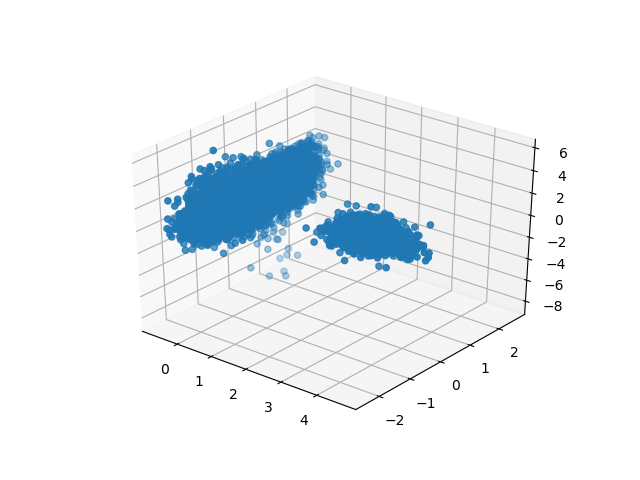

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*graph_cca.T)

# Clustering